In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report   
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
## LOAD AND COMBINE FULL DATA ON EOG READINGS AND SACCADE LABELS

p1_EOG = pd.read_csv('./Malta_Data_P1/EOG_transposed.csv')
p1_labels = pd.read_csv('./Malta_Data_P1/ControlSignal_transposed.csv')
p1_data = pd.concat([p1_EOG, p1_labels], axis=1)
p1_data = p1_data.rename({'Var1': 'saccade_type'}, axis = 1)
p1_data = p1_data.drop(0).reset_index(drop=True)
p1_data = p1_data.drop(p1_data.shape[0]-1).reset_index(drop=True)
p1_data

,Horizontal,Vertical,saccade_type
0,1.203125,-0.244141,1
1,2.419922,-0.109375,1
2,3.550781,0.523438,1
3,4.530273,1.436523,1
4,5.327148,2.210938,1
...,...,...,...
312331,954.335938,-5707.664062,3
312332,954.087891,-5708.382812,3
312333,952.593750,-5708.121094,3
312334,950.516602,-5706.533203,3


In [5]:
#SEGMENT DATA INTO RESPECTIVE SACCADES AND BLINKS

p1_data['group'] = (p1_data['saccade_type'] != p1_data['saccade_type'].shift()).cumsum()

# split into a list of DataFrames
segments = [g.drop(columns='group').reset_index(drop=True)
            for _, g in p1_data.groupby('group')]
print(len(segments))
segments

900


[     Horizontal   Vertical  saccade_type
 0      1.203125  -0.244141             1
 1      2.419922  -0.109375             1
 2      3.550781   0.523438             1
 3      4.530273   1.436523             1
 4      5.327148   2.210938             1
 ..          ...        ...           ...
 261  -90.202148 -87.812500             1
 262  -90.839844 -87.462891             1
 263  -91.902344 -87.768555             1
 264  -92.888672 -88.680664             1
 265  -93.381836 -89.691406             1
 
 [266 rows x 3 columns],
      Horizontal    Vertical  saccade_type
 0    -93.237305  -90.134766             2
 1    -92.658203  -89.614258             2
 2    -92.041992  -88.283203             2
 3    -91.773438  -86.791992             2
 4    -92.036133  -85.909180             2
 ..          ...         ...           ...
 259   21.145508 -126.071289             2
 260   20.566406 -126.528320             2
 261   20.343750 -125.420898             2
 262   20.663086 -123.209961           

SINCE the FORWARD SACCADES ARE THE ONLY ONES THAT CONTAIN INITIAL MOVEMENT FROM THE REFERENCE POINT of the CENTER OF THE SCREEN, THEY ARE THE ONLY ONES WE CARE ABOUT FOR COORDINATE MAPPING. THE RETURN SACCADES ARE DEPENDENT ON THE FORWARD SACCADES AND ARE REDUNDANT


In [6]:
#SELECT ONLY SACCADES
fw_saccades = [seg for seg in segments if seg['saccade_type'].iloc[0] == 1]
len(fw_saccades)

300

In [7]:
bw_saccades = [seg for seg in segments if seg['saccade_type'].iloc[0] == 2]
len(bw_saccades)

300

In [8]:
#SELECT ONLY BLINKS
blinks = [seg for seg in segments if seg['saccade_type'].iloc[0] == 3]

In [9]:
#IMPORT GAZE LABELS FOR EOG DATA
p1_gaze = pd.read_csv('./Malta_Data_P1/TargetGA.csv')
p1_gaze = p1_gaze.rename({'TargetGA_1': 'angle_horiz', 'TargetGA_2': 'angle_vert'}, axis=1)

In [10]:
p1_gaze = p1_gaze[p1_gaze['angle_horiz'] != 0].reset_index(drop=True)
p1_gaze

,angle_horiz,angle_vert
0,-3.806537,-1.037786
1,19.470698,-13.191816
2,13.955018,11.270787
3,21.343281,1.551274
4,7.544489,10.527502
...,...,...
295,8.553844,3.336264
296,-13.963720,-10.103950
297,-8.793077,-7.664676
298,-17.297037,0.948573


In [11]:
## GAZE TO COORDINATES
def gaze_to_coordinates(angle_horiz, angle_vert, distance=60):
    x = distance * np.tan((np.radians(angle_horiz)))
    y = distance * np.tan((np.radians(angle_vert)))
    return x, y
p1_coords = pd.DataFrame()
p1_coords['x'], p1_coords['y'] = gaze_to_coordinates(p1_gaze['angle_horiz'], p1_gaze['angle_vert'])
p1_coords

,x,y
0,-3.992071,-1.086885
1,21.212588,-14.063831
2,14.909656,11.957373
3,23.445251,1.624888
4,7.946550,11.150135
...,...,...
295,9.024713,3.497681
296,-14.919332,-10.691895
297,-9.281068,-8.074654
298,-18.684515,0.993434


In [12]:
#MAP EOG READINGS TO GAZE ANGLES

fw_mapping = {
    i: {'segment': seg, 
        'x': p1_coords.loc[i, 'x'], 
        'y': p1_coords.loc[i, 'y']}
    for i, seg in enumerate(fw_saccades)
}

bw_mapping = {
    i: {'segment': seg, 
        'angle_horiz': 0, 
        'angle_vert': 0}
    for i, seg in enumerate(bw_saccades)
}


# REGRESSION

In [13]:
all_segments = []
for i, entry in fw_mapping.items():
    seg = entry['segment'].copy()
    seg['saccade_id'] = i
    seg['x'] = entry['x']
    seg['y'] = entry['y']
    all_segments.append(seg)

df = pd.concat(all_segments, ignore_index=True)
df

,Horizontal,Vertical,saccade_type,saccade_id,x,y
0,1.203125,-0.244141,1,0,-3.992071,-1.086885
1,2.419922,-0.109375,1,0,-3.992071,-1.086885
2,3.550781,0.523438,1,0,-3.992071,-1.086885
3,4.530273,1.436523,1,0,-3.992071,-1.086885
4,5.327148,2.210938,1,0,-3.992071,-1.086885
...,...,...,...,...,...,...
78072,1099.191406,-5855.404297,1,299,8.748763,-8.900241
78073,1098.814453,-5859.240234,1,299,8.748763,-8.900241
78074,1098.256836,-5864.255859,1,299,8.748763,-8.900241
78075,1097.520508,-5868.650391,1,299,8.748763,-8.900241


## BASELINE NORMALIZATION

Baseline normalization necessary so that all EOG readings start near zero. Accounting for baseline differences between forward saccades. Because we are only concerned with patterns and shapes of the EOG curves during different forward saccades we must make sure the values start at the same number. Example: perhaps a users EOG is raised over time at the center point due to fatigue or consecutive saccades, where it really should be the same every time (independent of the # trials)

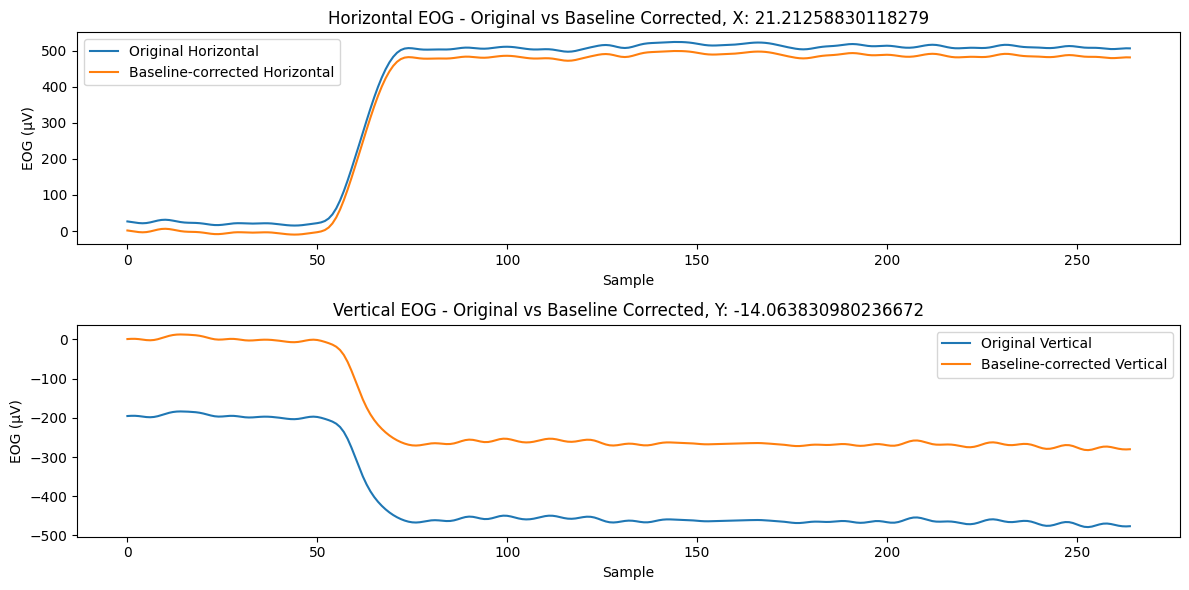

In [14]:
import matplotlib.pyplot as plt

# Pick a segment to visualize (e.g., the first one)
#FORWARDS
fw_entry = list(fw_mapping.values())[1]
fw_horiz = fw_entry['segment']['Horizontal'].values.astype('float32')
fw_vert  = fw_entry['segment']['Vertical'].values.astype('float32')

# Baseline subtraction using first 10 samples (pre-saccade fixation)
pre_samples = 10
fw_horiz_baseline = fw_horiz - fw_horiz[:pre_samples].mean()
fw_vert_baseline  = fw_vert  - fw_vert[:pre_samples].mean()

# Plot
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(fw_horiz, label='Original Horizontal')
plt.plot(fw_horiz_baseline, label='Baseline-corrected Horizontal')
plt.title('Horizontal EOG - Original vs Baseline Corrected, X: ' + str(fw_entry['x']))
plt.xlabel('Sample')
plt.ylabel('EOG (µV)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(fw_vert, label='Original Vertical')
plt.plot(fw_vert_baseline, label='Baseline-corrected Vertical')
plt.title('Vertical EOG - Original vs Baseline Corrected, Y: ' + str(fw_entry['y']))
plt.xlabel('Sample')
plt.ylabel('EOG (µV)')
plt.legend()

# #BACKWARDS
# bw_entry = list(bw_mapping.values())[1]
# bw_horiz = bw_entry['segment']['Horizontal'].values.astype('float32')
# bw_vert  = bw_entry['segment']['Vertical'].values.astype('float32')

# # Baseline subtraction using first 10 samples (pre-saccade fixation)
# pre_samples = 10
# bw_horiz_baseline = bw_horiz - bw_horiz[:pre_samples].mean()
# bw_vert_baseline  = bw_vert  - bw_vert[:pre_samples].mean()

# # Plot
# plt.figure(figsize=(12,5))

# plt.subplot(2,1,1)
# plt.plot(bw_horiz, label='Original Horizontal')
# plt.plot(bw_horiz_baseline, label='Baseline-corrected Horizontal')
# plt.title('BACKWARDS - Horizontal EOG - Original vs Baseline Corrected, ANGLE: ' + str(bw_entry['angle_horiz']))
# plt.xlabel('Sample')
# plt.ylabel('EOG (µV)')
# plt.legend()

# plt.subplot(2,1,2)
# plt.plot(bw_vert, label='Original Vertical')
# plt.plot(bw_vert_baseline, label='Baseline-corrected Vertical')
# plt.title('BACKWARDS - Vertical EOG - Original vs Baseline Corrected, ANGLE: ' + str(bw_entry['angle_vert']))
# plt.xlabel('Sample')
# plt.ylabel('EOG (µV)')
# plt.legend()

plt.tight_layout()
plt.show()


0.0
-4.383789


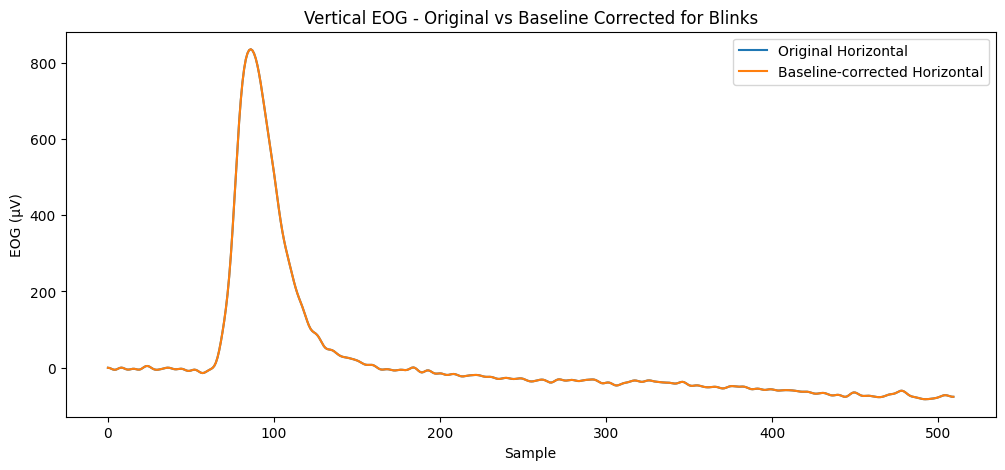

In [15]:
## VISUALIZE BLINK SIGNAL
#Check if Blinks need to be Normalized
# for i in range(len(blinks)):
#     if blinks[i]['Vertical'][0] != 0:
#         print('first value not equal to 0', blinks[i]['Vertical'][0])
    
# BASELINE NORMALIZE THE BLINKS
pre_samples = 10

X_v_list_blinks = []
for entry in blinks:
    blink_vert_norm = entry['Vertical'].values
    baseline_v_blinks = blink_vert_norm[0]
    blink_vert_norm -= baseline_v_blinks
    X_v_list_blinks.append(blink_vert_norm)

blink_entry = blinks[0]
blink_vert  = blink_entry['Vertical'].values.astype('float32')

print(X_v_list_blinks[3][0])
print(blink_vert[3])

plt.figure(figsize=(12,5))
plt.plot(blink_vert, label='Original Horizontal')
plt.plot(X_v_list_blinks[0], label='Baseline-corrected Horizontal')
plt.title('Vertical EOG - Original vs Baseline Corrected for Blinks')
plt.xlabel('Sample')
plt.ylabel('EOG (µV)')
plt.legend()

## ANALYZE RELATIONSHIP BETWEEN DELTAEOG AND COORDS

max y:  14.042033971211815 min y -14.088451733477783
max x:  24.92224132284022 min x -25.11309438365327


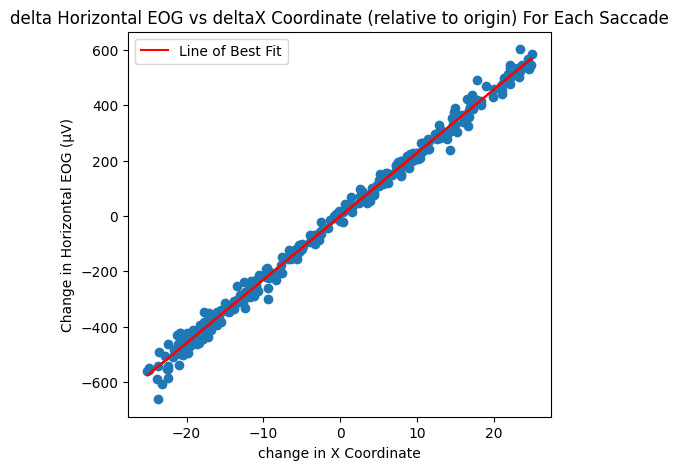

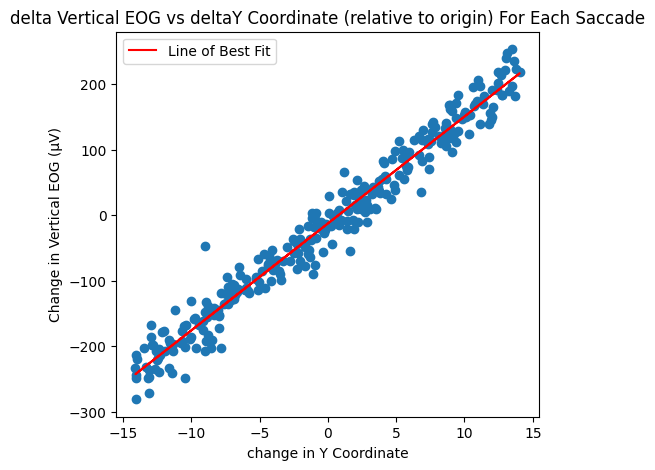

In [16]:
deltaEOG_h = []
deltaEOG_v = []
deltaX = []
deltaY = []
for entry in fw_mapping.values():
    horiz = entry['segment']['Horizontal'].values.astype('float32')
    vert  = entry['segment']['Vertical'].values.astype('float32')
    deltaEOG_h.append(horiz[-1] - horiz[0])
    deltaEOG_v.append(vert[-1]  - vert[0])
    deltaX.append(entry['x'] - 0)  # assuming starting angle is 0
    deltaY.append(entry['y'] - 0)  # assuming starting angle is 0

print('max y: ', max(deltaY), 'min y',  min(deltaY))
print('max x: ', max(deltaX), 'min x',  min(deltaX))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(deltaX, deltaEOG_h)
plt.xlabel('change in X Coordinate')
plt.ylabel('Change in Horizontal EOG (µV)')
plt.title('delta Horizontal EOG vs deltaX Coordinate (relative to origin) For Each Saccade')

slope, intercept = np.polyfit(deltaX, deltaEOG_h, 1)
plt.plot(deltaX, slope * np.array(deltaX) + intercept, color='red', label='Line of Best Fit')   
plt.legend()


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(deltaY, deltaEOG_v)
plt.xlabel('change in Y Coordinate')
plt.ylabel('Change in Vertical EOG (µV)')
plt.title('delta Vertical EOG vs deltaY Coordinate (relative to origin) For Each Saccade')

slope, intercept = np.polyfit(deltaY, deltaEOG_v, 1)
plt.plot(deltaY, slope * np.array(deltaY) + intercept, color='red', label='Line of Best Fit')   
plt.legend()



In [17]:
#PARAMETERS
Fs = 256                 # sampling frequency
max_len = Fs             # maximum samples per segment (~1 second)
pre_samples = 10         # optional baseline window

# SEGMENTS AND TARGET COORDINATES
X_h_list = []
X_v_list = []
y_h_list = []
y_v_list = []

for entry in fw_mapping.values():
    horiz = entry['segment']['Horizontal'].values.astype('float32')
    vert  = entry['segment']['Vertical'].values.astype('float32')
    
    # Baseline normalization using first `pre_samples`
    baseline_h = horiz[:pre_samples].mean() if len(horiz) >= pre_samples else horiz.mean()
    baseline_v = vert[:pre_samples].mean()  if len(vert)  >= pre_samples else vert.mean()
    horiz -= baseline_h
    vert  -= baseline_v
    
    X_h_list.append(horiz)
    X_v_list.append(vert)
    
    # Target: one coordinate per segment
    y_h_list.append(entry['x'])
    y_v_list.append(entry['y'])

# Pad sequences to max_len
X_h = pad_sequences(X_h_list, maxlen=max_len, dtype='float32', padding='post')
X_v = pad_sequences(X_v_list, maxlen=max_len, dtype='float32', padding='post')

# Reshape for LSTM input: (samples, timesteps, features)
X_h = X_h[..., np.newaxis]
X_v = X_v[..., np.newaxis]
print('Predictor Shapes: ', X_h.shape, X_v.shape)

y_h = np.array(y_h_list, dtype='float32')
y_v = np.array(y_v_list, dtype='float32')
print('Target Shapes: ', y_h.shape, y_v.shape)

#TRAIN TEST SPLIT
num_segments = X_h.shape[0]
indices = np.arange(num_segments)

# 70% train, 15% val, 15% test
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42, shuffle=True)
val_idx, test_idx   = train_test_split(temp_idx, test_size=0.5, random_state=42, shuffle=True)

# Horizontal data splits
X_train_h, y_train_h = X_h[train_idx], y_h[train_idx]
X_val_h,   y_val_h   = X_h[val_idx],   y_h[val_idx]
X_test_h,  y_test_h  = X_h[test_idx],  y_h[test_idx]

# Vertical data splits
X_train_v, y_train_v = X_v[train_idx], y_v[train_idx]
X_val_v,   y_val_v   = X_v[val_idx],   y_v[val_idx]
X_test_v,  y_test_v  = X_v[test_idx],  y_v[test_idx]

Predictor Shapes:  (300, 256, 1) (300, 256, 1)
Target Shapes:  (300,) (300,)


## LINEAR REGRESSION

In [18]:
linear_model_h = LinearRegression()
linear_model_v = LinearRegression()

linear_model_h.fit(X_train_h.reshape(X_train_h.shape[0], -1), y_train_h)
linear_model_v.fit(X_train_v.reshape(X_train_v.shape[0], -1), y_train_v)

linear_x_pred = linear_model_h.predict(X_test_h.reshape(X_test_h.shape[0], -1))
linear_y_pred = linear_model_v.predict(X_test_v.reshape(X_test_v.shape[0], -1))

print("Horizontal Linear Regression:")
print("R²:", r2_score(y_test_h, linear_x_pred))
print("RMSE:", root_mean_squared_error(y_test_h, linear_x_pred))

print("\nVertical Linear Regression:")
print("R²:", r2_score(y_test_v, linear_y_pred))
print("RMSE:", root_mean_squared_error(y_test_v, linear_y_pred))


Horizontal Linear Regression:
R²: 0.9957534670829773
RMSE: 0.9633049368858337

Vertical Linear Regression:
R²: 0.9737701416015625
RMSE: 1.3340378999710083


## LSTM

In [ ]:
#LSTM MODEL
def build_lstm_model(input_shape):
    model = Sequential([
        Masking(mask_value=0., input_shape=input_shape),  # ignore padded zeros
        LSTM(32, activation='tanh'),
        Dense(1)  # regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model_h = build_lstm_model((X_h.shape[1], 1))
model_v = build_lstm_model((X_v.shape[1], 1))

#TRAIN MODELS
history_h = model_h.fit(X_train_h, y_train_h, validation_data=(X_val_h, y_val_h), epochs=100, batch_size=16)
history_v = model_v.fit(X_train_v, y_train_v, validation_data=(X_val_v, y_val_v), epochs=100, batch_size=16)

#PREDICT AND EVALUATE
y_pred_h = model_h.predict(X_test_h)
y_pred_v = model_v.predict(X_test_v)

print("Horizontal LSTM:")
print("R²:", r2_score(y_test_h, y_pred_h))
print("RMSE:", root_mean_squared_error(y_test_h, y_pred_h))

print("\nVertical LSTM:")
print("R²:", r2_score(y_test_v, y_pred_v))
print("RMSE:", root_mean_squared_error(y_test_v, y_pred_v))


NameError: name 'X_h' is not defined

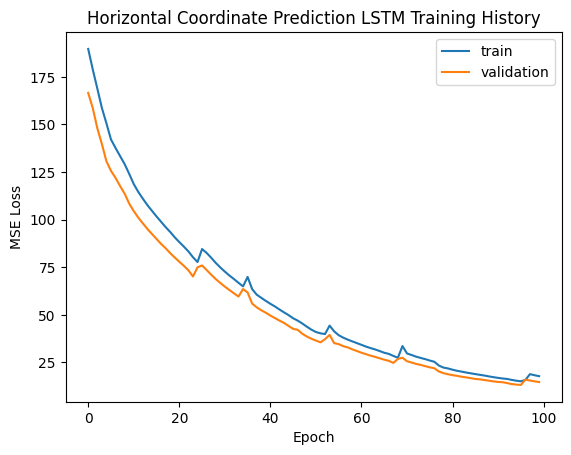

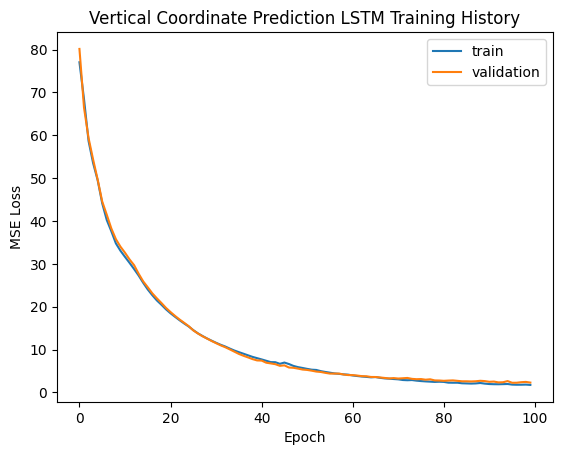

In [ ]:

# Check for Overfitting
import matplotlib.pyplot as plt
plt.plot(history_h.history['loss'], label='train')
plt.plot(history_h.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Horizontal Coordinate Prediction LSTM Training History')
plt.legend()
plt.show()

plt.plot(history_v.history['loss'], label='train')
plt.plot(history_v.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Vertical Coordinate Prediction LSTM Training History')
plt.legend()
plt.show()


# BLINK VS SACCADE CLASSIFICATION

In [ ]:
blink_mapping = {
    i: {'blink': seg, 
        'label': 1}
    for i, seg in enumerate(X_v_list_blinks)
}

saccade_mapping = {
    i: {'vert_segment': seg['Vertical'], 
        'label' : 0}
    for i, seg in enumerate(fw_saccades)
}

0     -195.533203
1     -194.983398
2     -194.942383
3     -195.678711
4     -196.959961
          ...    
260   -472.938477
261   -475.072266
262   -476.491211
263   -476.875977
264   -476.354492
Name: Vertical, Length: 265, dtype: float64

In [ ]:
#PARAMETERS
Fs = 256                 # sampling frequency
max_len = Fs             # maximum samples per segment (~1 second)
pre_samples = 10         # optional baseline window

# SEGMENTS AND TARGET COORDINATES
X_blinks_list = []
y_blinks_list = []
X_v_saccade_list = []
y_v_saccade_list = []

for entry in saccade_mapping.values():
    vert  = entry['segment']['Vertical'].values.astype('float32')
    # Baseline normalization using first `pre_samples`
    baseline_v = vert[:pre_samples].mean()  if len(vert)  >= pre_samples else vert.mean()
    vert  -= baseline_v
    
    X_v_saccade_list.append(vert)
    
    # Target: one coordinate per segment
    y_v_list.append(entry['label'])

# Pad sequences to max_len
X_v = pad_sequences(X_v_list, maxlen=max_len, dtype='float32', padding='post')

# Reshape for LSTM input: (samples, timesteps, features)
X_v = X_v[..., np.newaxis]
print('Predictor Shapes: ', X_h.shape, X_v.shape)

y_h = np.array(y_h_list, dtype='float32')
y_v = np.array(y_v_list, dtype='float32')
print('Target Shapes: ', y_h.shape, y_v.shape)

#TRAIN TEST SPLIT
num_segments = X_h.shape[0]
indices = np.arange(num_segments)

# 70% train, 15% val, 15% test
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42, shuffle=True)
val_idx, test_idx   = train_test_split(temp_idx, test_size=0.5, random_state=42, shuffle=True)

# Horizontal data splits
X_train_h, y_train_h = X_h[train_idx], y_h[train_idx]
X_val_h,   y_val_h   = X_h[val_idx],   y_h[val_idx]
X_test_h,  y_test_h  = X_h[test_idx],  y_h[test_idx]

# Vertical data splits
X_train_v, y_train_v = X_v[train_idx], y_v[train_idx]
X_val_v,   y_val_v   = X_v[val_idx],   y_v[val_idx]
X_test_v,  y_test_v  = X_v[test_idx],  y_v[test_idx]